# Microbiome machine learning analysis

## Setup

### Import the calour module

In [38]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from calour.training import plot_scatter, plot_roc, plot_cm

In [17]:
import calour as ca

In [18]:
%matplotlib notebook

## Regression 

### Loading the data

We will use the data from Qitta study 103 (https://qiita.ucsd.edu/study/description/103#)

In [19]:
dat=ca.read_amplicon('data/88-soil.biom',
                     'data/88-soil.sample.txt',
                     normalize=100,min_reads=10)

In [20]:
print(dat)

AmpliconExperiment ("88-soil.biom") with 88 samples, 7396 features


### Process the data

#### Get rid of the features (bacteria) with small amount of reads
We throw away all features with total reads (over all samples) < 1 (after each sample was normalized to 100 reads/sample). Note alternatively we could filter based on mean reads/sample or fraction of samples where the feature is present. Each method filters away slightly different bacteria. See **filtering** notebook for details on the filtering functions.

In [22]:
dat=dat.filter_abundance(1)
dat

AmpliconExperiment ("88-soil.biom") with 88 samples, 1756 features

#### Use soil microbiome to predict its pH

Let's look at the distribution of pH for all the samples:

<IPython.core.display.Javascript object>


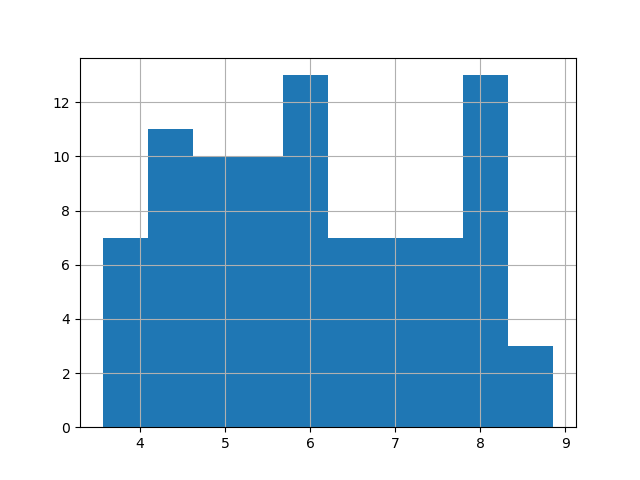

In [7]:
dat.sample_metadata['ph'].hist()

<IPython.core.display.Javascript object>


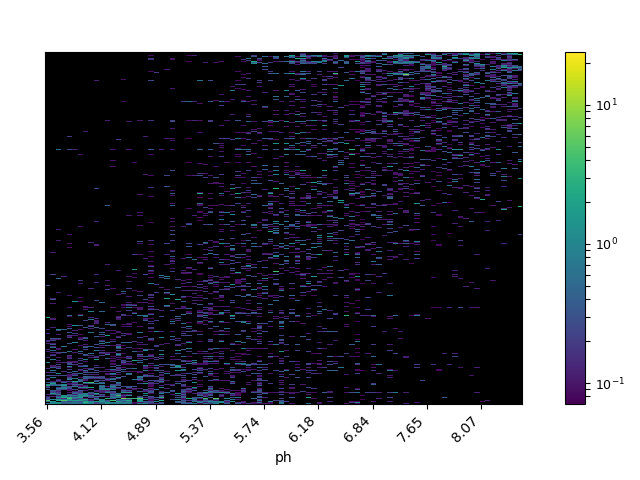

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [8]:
dat.sort_samples('ph').sort_centroid(n=0.001).plot(sample_field='ph', gui='jupyter')

We can then run regression analysis:

In [9]:
it = dat.regress('ph', RandomForestRegressor(random_state=0), cv=5, params=[{'n_estimators':3}, {'n_estimators': 500}])

This function returns a generator, which yields the prediction result for each parameter set specified in `params`. Here we would like to see how the number of trees (named `n_estimators`) in the model impact its performance. The result with `n_estimators = 10` is:

In [10]:
res1 = next(it)

In [11]:
res1.head()

CV   SAMPLE    Y_PRED  Y_TRUE
0   0  103.CA2  7.656667    8.02
1   0  103.CO3  7.143333    6.02
2   0  103.SR3  7.350000    6.95
3   0  103.IE2  5.726667    5.52
4   0  103.BP1  6.476667    7.53

We can plot out the result as following. Each dot is a sample with observed and predicted pH, colored by the fold of cross validation the sample is from. The diagonal line indicates perfect predition. The correlation coefficient and its p-value between the prediction and observation are also annotated around the top of the plot.

<IPython.core.display.Javascript object>


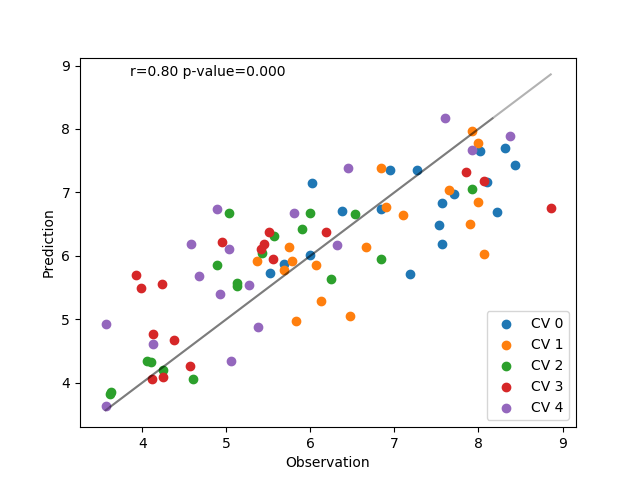

In [13]:
plot_scatter(res1, cv=True)

Let's look at the result for `n_estimators = 500`:

In [14]:
res2 = next(it)

In [15]:
res2.head()

CV   SAMPLE   Y_PRED  Y_TRUE
0   0  103.CA2  7.02582    8.02
1   0  103.CO3  6.36924    6.02
2   0  103.SR3  7.51494    6.95
3   0  103.IE2  5.55394    5.52
4   0  103.BP1  7.03446    7.53

<IPython.core.display.Javascript object>


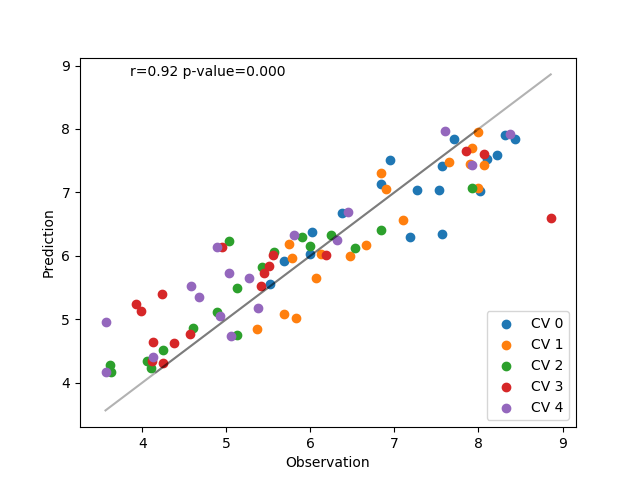

In [16]:
plot_scatter(res2, cv=True)

From the plot, you can see, with more trees in the Random Forest model, the prediction is much better with a higher correlation coefficient.

## Classification

We can do analysis similarly for classification. Let's show it with another data set that was introduced in previous notebook.

In [23]:
dat=ca.read_amplicon('data/chronic-fatigue-syndrome.biom',
                     'data/chronic-fatigue-syndrome.sample.txt',
                     normalize=10000,min_reads=1000)

2018-08-13 14:28:32 WARNING These have metadata but do not have data - dropped: {'ERR1331814'}


In [24]:
print(dat)

AmpliconExperiment ("chronic-fatigue-syndrome.biom") with 87 samples, 2129 features


Let's see if we can distinguish patient samples from control samples with classification:

In [25]:
dat.sample_metadata['Subject'].value_counts()

Patient    48
Control    39
Name: Subject, dtype: int64

In [31]:
it = dat.classify('Subject', RandomForestClassifier(random_state=0), cv=RepeatedStratifiedKFold(5, 3), params=[{'n_estimators':3}, {'n_estimators': 500}])

In [32]:
res1 = next(it)

In [33]:
res1.head()

Control   Patient   Y_TRUE      SAMPLE  CV
0  0.333333  0.666667  Patient  ERR1331791   0
1  0.000000  1.000000  Control  ERR1331854   0
2  0.333333  0.666667  Patient  ERR1331838   0
3  0.666667  0.333333  Patient  ERR1331789   0
4  0.333333  0.666667  Control  ERR1331827   0

We can plot out the result as ROC curve or confusion matrix.

<IPython.core.display.Javascript object>


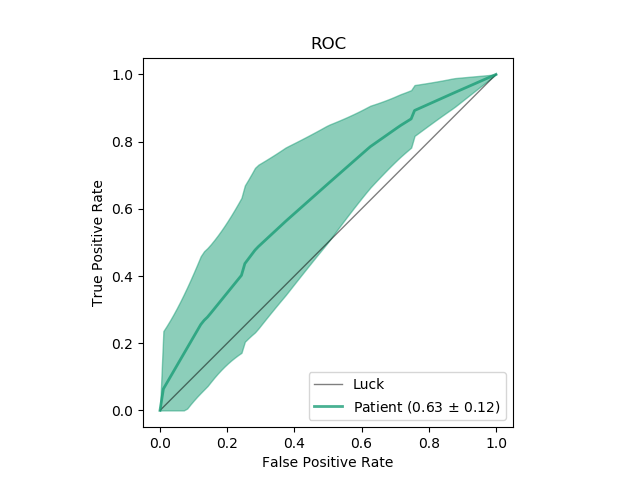

In [34]:
plot_roc(res1, classes=['Patient'])

You can also plot confustion matrix:

<IPython.core.display.Javascript object>


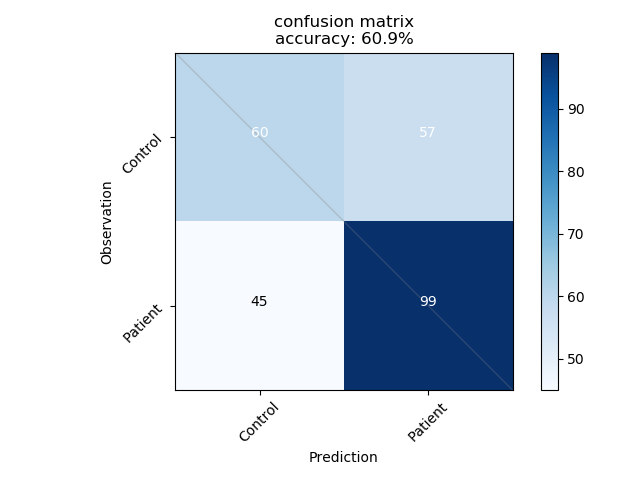

In [42]:
plot_cm(res1)

Let's look at the result for `n_estimators = 500`:

In [35]:
res2 = next(it)

In [36]:
res2.head()

Control  Patient   Y_TRUE      SAMPLE  CV
0    0.172    0.828  Patient  ERR1331790   0
1    0.548    0.452  Patient  ERR1331844   0
2    0.588    0.412  Patient  ERR1331843   0
3    0.634    0.366  Control  ERR1331826   0
4    0.266    0.734  Patient  ERR1331869   0

<IPython.core.display.Javascript object>


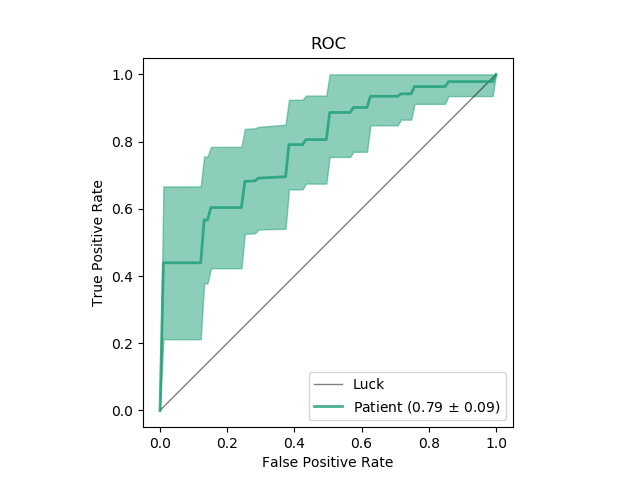

In [37]:
plot_roc(res2, classes=['Patient'])

You can also plot confustion matrix:

<IPython.core.display.Javascript object>


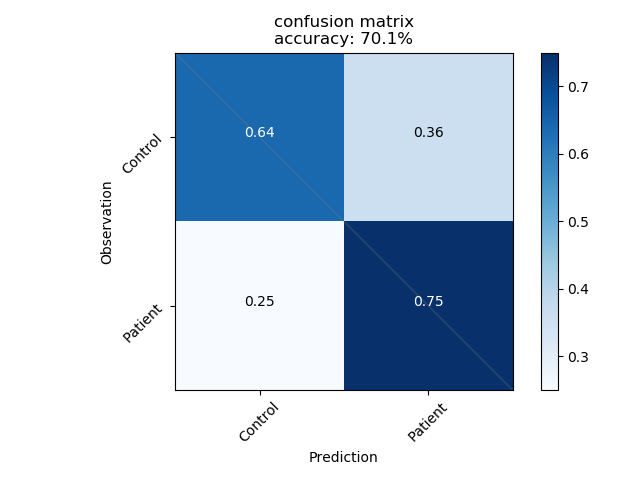

In [41]:
plot_cm(res2, normalize=True)

From the confusion matrix and ROC plots, you can see, with more trees in the Random Forest model, similar to regression, the classification accuracy is much better.